#### This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


In [24]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import metrics as skm



from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas


from aif360.sklearn.metrics import make_scorer, statistical_parity_difference, consistency_score
from aif360.sklearn.preprocessing import LearnedFairRepresentations


from skl2onnx import convert_sklearn
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx




In [25]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

#### Load dataset and set options

In [26]:
## import dataset

data = pd.read_csv('./../data/synth_data_for_training.csv')
print(data.info())

data = data.astype(np.float32)
# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = data.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# test_data = X_test.join(y_test, how='outer', lsuffix=suffixes['checked'], rsuffix=suffixes['checked'])

train_dataset = StandardDataset(
    X_train,
    label_name="checked",
    favorable_classes=[1],
    protected_attribute_names=["persoon_geslacht_vrouw"],
    privileged_classes=[[1, 0]],
)

train_dataset = StandardDataset(
    X_test,
    label_name="checked",
    favorable_classes=[1],
    protected_attribute_names=["persoon_geslacht_vrouw"],
    privileged_classes=[[1, 0]],
)

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Columns: 316 entries, adres_aantal_brp_adres to checked
dtypes: int64(316)
memory usage: 30.5 MB
None


#### Split into train, and test

In [27]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = train_dataset.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = train_dataset.split([0.5], shuffle=True)

#### Clean up training data

In [28]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(2213, 315)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['persoon_geslacht_vrouw']


#### Privileged and unprivileged protected attribute values

[array([1., 0.])] [array([], dtype=float64)]


#### Dataset feature names

['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden', 'adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru', 'adres_unieke_wijk_ratio', 'afspraak_aanmelding_afgesloten', 'afspraak_aantal_woorden', 'afspraak_afgelopen_jaar_afsprakenplan', 'afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel', 'afspraak_afgelopen_jaar_on

#### Metric for original training data

In [29]:
# Metric for the original dataset
# print(dataset_orig_train.convert_to_dataframe()['persoon_geslacht_vrouw'])
metric_orig_train = BinaryLabelDatasetMetric(train_dataset, 
                                             unprivileged_groups=[{'persoon_geslacht_vrouw': 1}],
                                             privileged_groups=[{'persoon_geslacht_vrouw': 0}])
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.008839


In [35]:
def discrimination(y_true, y_pred):
    return abs(statistical_parity_difference(y_true, y_pred, prot_attr='persoon_geslacht_vrouw'))

def delta(y_true, y_pred, use_bal_acc=False):
    if use_bal_acc:
        return balanced_accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)
    else:
        return accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)

min_disc = make_scorer(statistical_parity_difference, prot_attr='persoon_geslacht_vrouw')
max_delta = skm.make_scorer(delta, use_bal_acc=True)

In [43]:
lfr = LearnedFairRepresentations('persoon_geslacht_vrouw', n_prototypes=25, max_iter=1, random_state=42)
params = {'reconstruct_weight': [1e-2, 1e-3, 1e-4], # [1e-2, 1e-3, 1e-4],
          'target_weight': [100], # [100, 1000],
          'fairness_weight': [100]} #  [0, 100, 1000]
# grid = GridSearchCV(lfr, params, scoring=max_delta, cv=1, n_jobs=8).fit(X_train, y_train)
grid = GridSearchCV(lfr, params, cv=1, n_jobs=8).fit(X_train, y_train)

res = pd.DataFrame(grid.cv_results_)
res

ValueError: 
All the 9 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\sklearn\preprocessing\learning_fair_representations.py", line 106, in fit
    groups, self.prot_attr_ = check_groups(X, self.prot_attr)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\sklearn\utils.py", line 83, in check_groups
    groups = df.set_index(prot_attr).index  # let pandas handle errors
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\pandas\core\frame.py", line 6109, in set_index
    raise KeyError(f"None of {missing} are in the columns")
KeyError: "None of ['persoon_geslacht_vrouw'] are in the columns"


#### Train with and transform the original training data

In [31]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

print(dataset_transf_train)

NameError: name 'unprivileged_groups' is not defined

In [ ]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

AssertionError: 

#### Metric with the transformed training data

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

ValueError: 'persoon_vrouw_geslacht' is not in list

In [ ]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

ValueError: 'persoon_vrouw_geslacht' is not in list

### Train classifier on original data

In [ ]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = GradientBoostingClassifier()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [ ]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [ ]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6899
Optimal classification threshold (no reweighing) = 0.6435


### Predictions from the original test set at the optimal classification threshold

In [ ]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6435


 74%|███████▍  | 74/100 [00:00<00:00, 733.89it/s]d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 723.13it/s]

Balanced accuracy = 0.6190
Statistical parity difference = 0.0000
Disparate impact = 1.0000
Average odds difference = 0.0038
Equal opportunity difference = 0.0400
Theil index = 0.3964


#### Display results for all thresholds

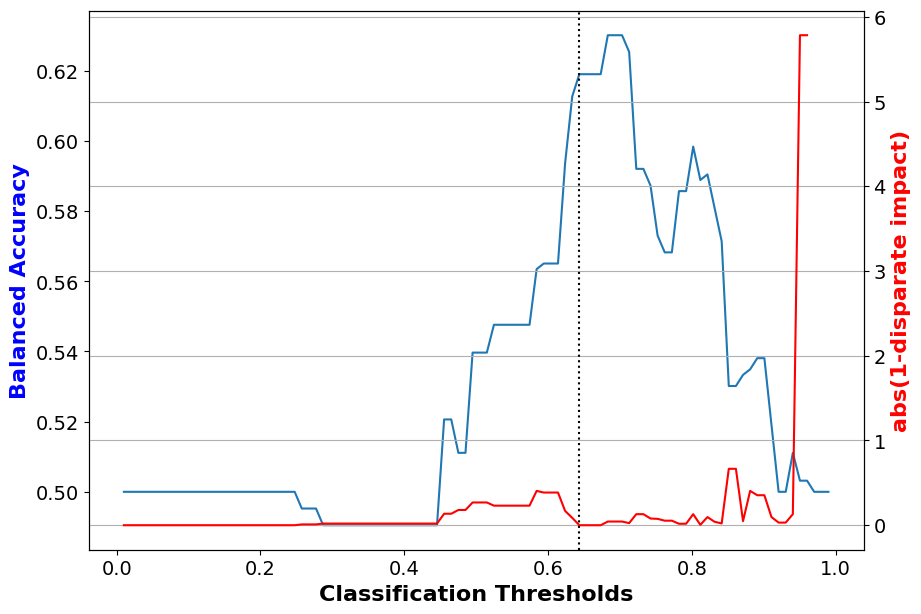

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

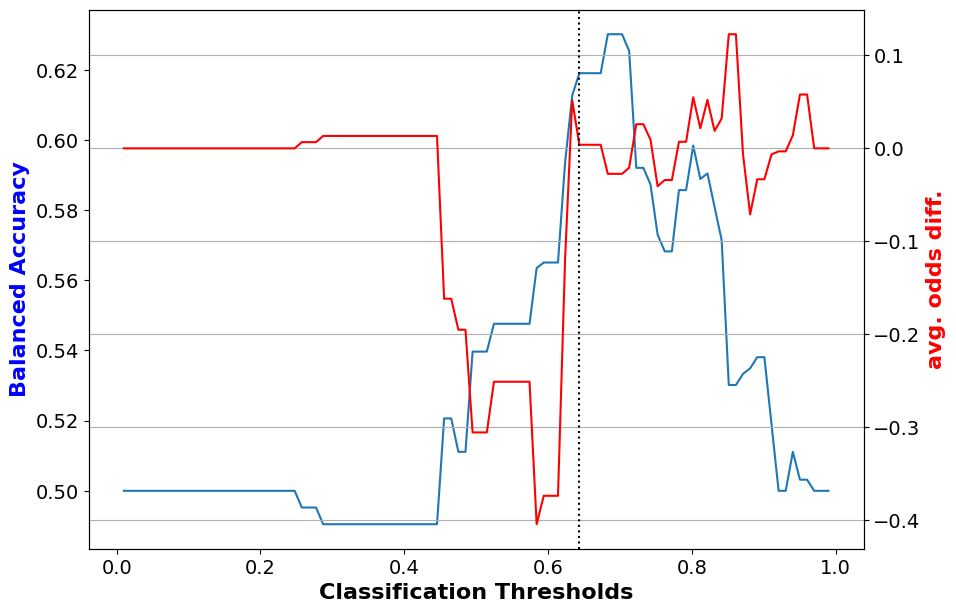

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [ ]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()


from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

lmod = GradientBoostingClassifier()


pipeline = Pipeline(steps=[('classification', lmod)])

pipeline.fit(dataset_transf_train.features, y_train)
y_train_pred = lmod.predict(X_train)


# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X_train.shape[1])))],
    target_opset=12)


# Let's save the model
onnx.save(onnx_model, "./../model/test6.onnx")


#### Obtain scores for transformed test set

In [ ]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [ ]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.7029


 71%|███████   | 71/100 [00:00<00:00, 707.61it/s]d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 805.43it/s]

Balanced accuracy = 0.6524
Statistical parity difference = -0.0025
Disparate impact = 0.9948
Average odds difference = 0.0071
Equal opportunity difference = 0.0400
Theil index = 0.3906


#### Display results for all thresholds

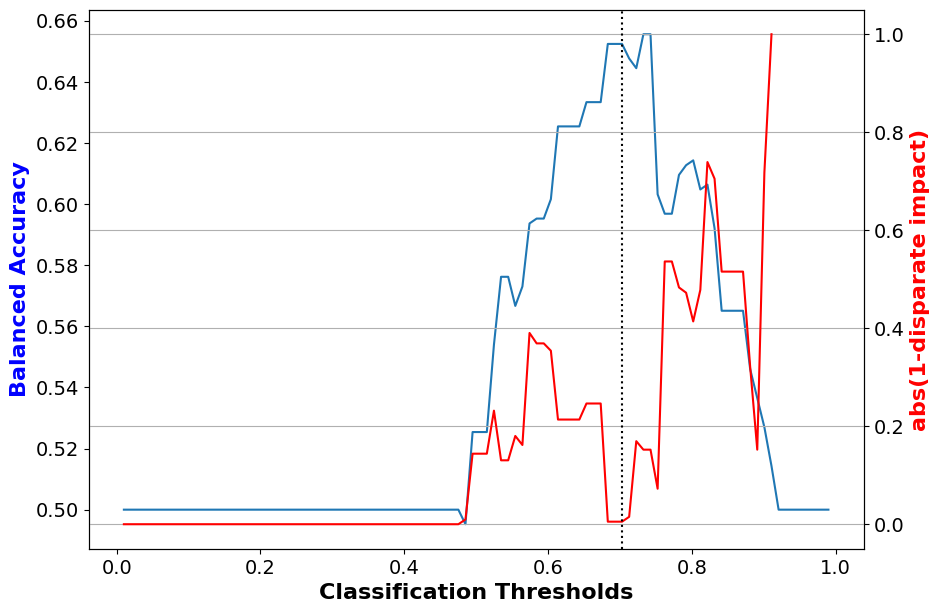

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

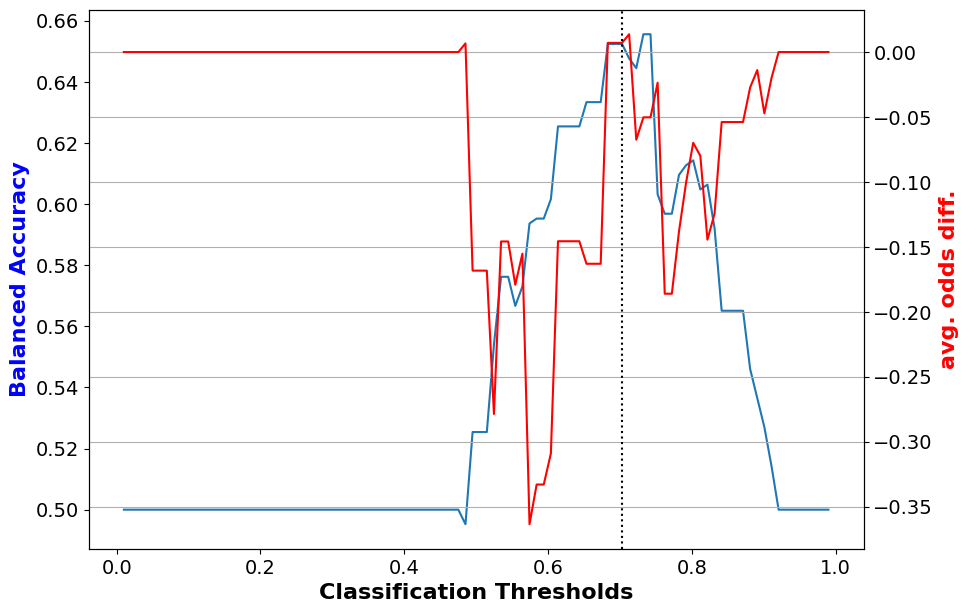

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult||0.2674|
|German|0.6732|
|Compas|0.5148|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|0.2774|0.7625|0.7417|0.7443|0.4423|0.7430|
|German (Test)|0.6524|0.6460|0.9948|1.0852|0.6524|0.6460|0.3824|0.5735|
|Compas (Test)|0.6774|0.6562|0.6631|0.8342|0.6774|0.6342|0.6600|1.1062|



### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|-0.3281|-0.0266|0.7417|0.7443|-0.1991|-0.0395|
|German (Test)|0.6524|0.6460|0.0071|0.0550|0.6524|0.6460|-0.3278|-0.1944|
|Compas (Test)|0.6774|0.6562|-0.2439|-0.0946|0.6774|0.6342|-0.1927|0.1042|